# Module 2
## Logistic Regression: Song Emotion

In [282]:
%matplotlib inline

import sys
PATH = '/Users/francescogemignani/Desktop/fma-proj'
sys.path.insert(0, PATH) 
from fma_metadata import utils

# Basic libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style

from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score, classification_report,confusion_matrix

#import random
from sklearn import preprocessing
#from sklearn.ensemble import IsolationForest
#from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

In [270]:
# utility function
def make_confusion_matrix( cfm, title):
    group_names = ['TN','FP','FN','TP']

    group_counts = ["{0:0.0f}".format(value) for value in
                cfm.flatten()]

    group_percentages = ["{0:.2%}".format(value) for value in
                     cfm.flatten()/np.sum(cf_matrix)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

    labels = np.asarray(labels).reshape(2,2)
    plt.title(title)
    
    sns.heatmap(cfm, annot=labels, fmt="", cmap='Blues')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted',fontsize=12)

In [271]:
from sklearn.metrics import roc_curve,auc

def plot_roc_curve(y_test, prediction, name_model):
    test_fpr, test_tpr, te_thresholds = roc_curve(y_test, prediction)

    plt.grid()
    auc_score = round(auc(test_fpr, test_tpr),2)
    plt.plot(test_fpr, test_tpr, label=f"{name_model} - AUC ="+ str(auc_score))
    plt.plot([0,1],[0,1],'r--')
    plt.legend()
    plt.xlabel("True Positive Rate")
    plt.ylabel("False Positive Rate")
    plt.title(f" AUC(ROC curve) - {name_model}")
    plt.grid(color='black', linestyle='', linewidth=0.5)
    plt.show()

## A) Data Preprocess

### A.1) Import Dataset

In [246]:
echonest = utils.load("/Users/francescogemignani/Google Drive/DM2/_FMA/fma_metadata/echonest.csv")

In [247]:
echo = echonest['echonest','audio_features']
echo.head()

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
track_id,,,,,,,,
2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661
3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240
5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661
10,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,111.562,0.963590
134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072


We use valence how song emotion: if valence is greater to 0.5 that song is labeled as 'happy', otherwise 'sad'. How we can see the distribution of 'valence' is balanced

<AxesSubplot:>

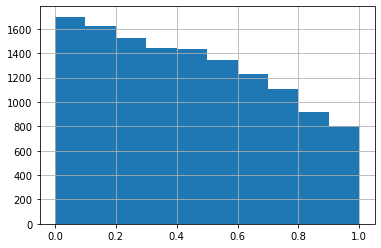

In [248]:
# distribution of valence
echo['valence'].hist()

In [249]:
# labeling valence 
echo['valence'] = echo['valence'].apply(lambda x: 'happy' if x>0.5 else 'sad')

In [250]:
# renaming valence as song_emotion
echo.rename({'valence': 'song_emotion'}, axis='columns', inplace=True)
echo.shape

(13129, 8)

In [251]:
echo['song_emotion'].value_counts()

sad      7724
happy    5405
Name: song_emotion, dtype: int64

In [252]:
# remove duplicate rows
echo.drop_duplicates(keep=False, inplace=True)

# remove Null values (if there are)
echo.dropna()

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,song_emotion
track_id,,,,,,,,
2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,happy
3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,sad
5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,happy
10,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,111.562,happy
134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,happy
...,...,...,...,...,...,...,...,...
124857,0.007592,0.790364,0.719288,0.853114,0.720715,0.082550,141.332,happy
124862,0.041498,0.843077,0.536496,0.865151,0.547949,0.074001,101.975,sad
124863,0.000124,0.609686,0.895136,0.846624,0.632903,0.051517,129.996,sad


### A.2) Anomaly Detection

In [253]:
# encoding labels
le = preprocessing.LabelEncoder()
echo['song_emotion'] = le.fit_transform(echo['song_emotion'])

print(f"Legend\n1: Sad\n0: Happy")
echo.song_emotion.value_counts()

Legend
1: Sad
0: Happy


1    7724
0    5405
Name: song_emotion, dtype: int64

In [254]:
# transform data in an np.ndarray 
X = np.array(echo)

#isolation-forest sklearn version
F0 = IsolationForest(random_state=42, n_estimators=300, contamination=0.05).fit(X) 

# score isolation forest - sklearn
outliers_sk = F0.predict(X)

# IsolationForest Sklearn
echo['outlier_IF_sklearn'] = outliers_sk
echo['outlier_IF_sklearn'] = echo['outlier_IF_sklearn'].apply(lambda x: 'inlier' if x==1 else 'outlier')

# sklearn IF
print(f"**** Anomaly detected*****'")
print(echo['outlier_IF_sklearn'].value_counts())
print()

echo = echo[echo['outlier_IF_sklearn'] == 'inlier']
echo.drop('outlier_IF_sklearn',axis=1,inplace=True)

**** Anomaly detected*****'
inlier     12472
outlier      657
Name: outlier_IF_sklearn, dtype: int64



### A.3) Splitting Data

In [255]:
print(f"Legend\n1: Sad\n0: Happy")
echo.head()

Legend
1: Sad
0: Happy


,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,song_emotion
track_id,,,,,,,,
2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0
3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,1
5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0
10,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,111.562,0
134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0


In [256]:
# remove labels from dataset 
labels = echo[['song_emotion']]
echo.drop('song_emotion', axis=1, inplace=True)

In [257]:
# split data in traning and test
X_train, X_test, y_train, y_test = train_test_split(echo, labels, test_size=0.30, random_state=42, stratify=labels,
                                                   shuffle=True) 

It is not correct to perform standardization before splitting the data. In general, you should not fit any preprocessing algorithm (PCA, StandardScaler...) on the whole dataset, but only on the training set, and use the fitted algorithm to transform the test set.

In [258]:
# normalize data
scaler = StandardScaler()
scaler.fit(X_train)
scaled_X_train = scaler.transform(X_train)
scaled_X_test = scaler.transform(X_test)

##### Visualize data in 2D with  PCA

In [263]:
from sklearn.decomposition import PCA
pca = PCA(2,random_state=42)
pca.fit(scaled_X_train)
pca_proj = pca.transform(scaled_X_train)

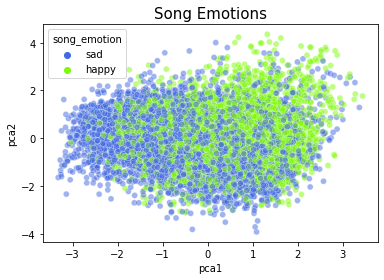

In [264]:
df = pd.DataFrame()
df['pca1'] = pca_proj[:,0]
df['pca2'] = pca_proj[:,1]
df['song_emotion'] = le.inverse_transform(y_train)
# plot scatter of PCA
plt.figure(figsize=(6,4))
sns.scatterplot(
    x="pca1", y="pca2",
    hue='song_emotion',
    palette={'happy':'lawngreen','sad':'royalblue'},
    data=df,
    c='black',
    legend="full",
    alpha=0.5
)
plt.title("Song Emotions", fontsize= 15)
plt.show()

## B) Logistic Regression Classifier
- Binary logistic regression requires the dependent variable to be binary.
- For a binary regression, the factor level 1 of the dependent variable should represent the desired outcome.
- Only the meaningful variables should be included.
- The independent variables should be independent of each other. That is, the model should have little or no multicollinearity.
- The independent variables are linearly related to the log odds.
- Logistic regression requires quite large sample sizes

### B.1) Attributes
In this case the dependent variable is 'song_emotion', which is the variable to predict. We've selected all echonest audio features (obviously no valence) as indepentend variable because all can influence the song emotion. Moreover how we can see, all independent variables are not correlated each others.

Legend
1: Sad
0: Happy


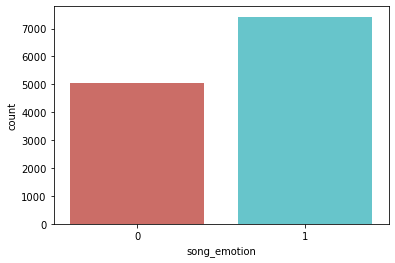

In [261]:
print(f"Legend\n1: Sad\n0: Happy")
sns.countplot(x='song_emotion',data=labels,palette='hls')
plt.show()

Text(0.5, 1.0, 'Echo-AudioFeatures correlations')

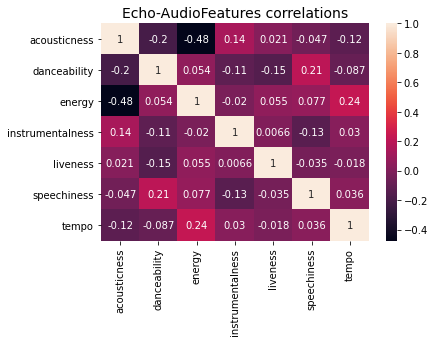

In [262]:
#Check echonest-audo features correlation
sns.heatmap(echo.corr(),annot=True)
plt.title("Echo-AudioFeatures correlations", fontsize=14)

### B.2) Recursive Feature Elimination
RFE is based on the idea to repeatedly construct a model and choose either the best or worst performing feature, setting the feature aside and then repeating the process with the rest of the features. This process is applied until all features in the dataset are exhausted. The goal of RFE is to select features by recursively considering smaller and smaller sets of features.

In our case, the target is to reduce the independent variable previously selected.

### B.2) Logistic Regression Model: without regularization

In [269]:
help(LogisticRegression)

Help on class LogisticRegression in module sklearn.linear_model._logistic:

class LogisticRegression(sklearn.base.BaseEstimator, sklearn.linear_model._base.LinearClassifierMixin, sklearn.linear_model._base.SparseCoefMixin)
 |  LogisticRegression(penalty='l2', *, dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver='lbfgs', max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)
 |  
 |  Logistic Regression (aka logit, MaxEnt) classifier.
 |  
 |  In the multiclass case, the training algorithm uses the one-vs-rest (OvR)
 |  scheme if the 'multi_class' option is set to 'ovr', and uses the
 |  cross-entropy loss if the 'multi_class' option is set to 'multinomial'.
 |  (Currently the 'multinomial' option is supported only by the 'lbfgs',
 |  'sag', 'saga' and 'newton-cg' solvers.)
 |  
 |  This class implements regularized logistic regression using the
 |  'liblinear' library, 'newton-cg', 's

In [275]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

#### Predict

In [287]:
y_pred = logreg.predict(X_test)
print(f"Legend\n1: Sad\n0: Happy")
print(classification_report(y_test, y_pred))

Legend
1: Sad
0: Happy
              precision    recall  f1-score   support

           0       0.64      0.55      0.59      1516
           1       0.72      0.79      0.75      2226

    accuracy                           0.69      3742
   macro avg       0.68      0.67      0.67      3742
weighted avg       0.69      0.69      0.69      3742



In [278]:
cf_matrix = confusion_matrix(y_test, y_pred)
cf_matrix

array([[ 838,  678],
       [ 467, 1759]])

Legend
1: Sad
0: Happy


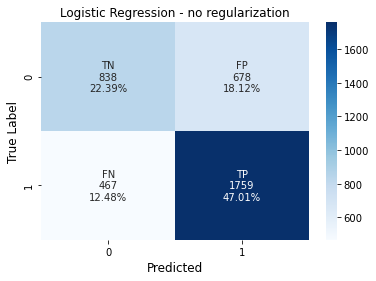

In [286]:
print(f"Legend\n1: Sad\n0: Happy")
make_confusion_matrix(cf_matrix, 'Logistic Regression - no regularization')

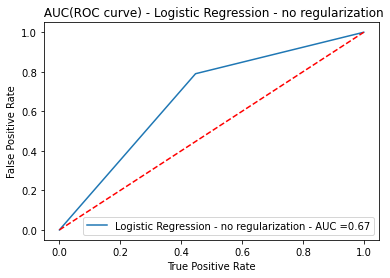

In [284]:
plot_roc_curve(y_test, y_pred, 'Logistic Regression - no regularization')